In [1]:
# source("https://bioconductor.org/biocLite.R")
# biocLite("DESeq2")
#install.packages("calibrate")
library(DESeq2)
library(gplots)
library(RColorBrewer)
library(calibrate)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

In [2]:
countdata = read.csv('../results/CvsAci.csv', header=TRUE, row.names=1)
countdata = as.matrix(countdata)
head(countdata)

,control1,control2,control3,Aci1,Aci2,Aci3
WBGene00000001,580,543,503,592,587,563
WBGene00000002,16,19,15,20,22,19
WBGene00000003,42,34,23,26,33,19
WBGene00000004,104,82,43,90,88,96
WBGene00000005,56,60,28,54,57,83
WBGene00000006,14,8,9,19,11,9


In [3]:
(condition = factor(c(rep("control",3), rep("Aci",3))))

[1] control control control Aci     Aci     Aci    
Levels: Aci control

In [4]:
(coldata = data.frame(row.names=colnames(countdata), condition))

,condition
control1,control
control2,control
control3,control
Aci1,Aci
Aci2,Aci
Aci3,Aci


In [5]:
dds = DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

it appears that the last variable in the design formula, 'condition',
  has a factor level, 'control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').


class: DESeqDataSet 
dim: 46748 6 
metadata(1): version
assays(1): counts
rownames(46748): WBGene00000001 WBGene00000002 ... WBGene00255587
  WBGene00255588
rowData names(0):
colnames(6): control1 control2 ... Aci2 Aci3
colData names(1): condition

In [6]:
(dds$condition = relevel(dds$condition, ref="control"))

[1] control control control Aci     Aci     Aci    
Levels: control Aci

In [7]:
dds = DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


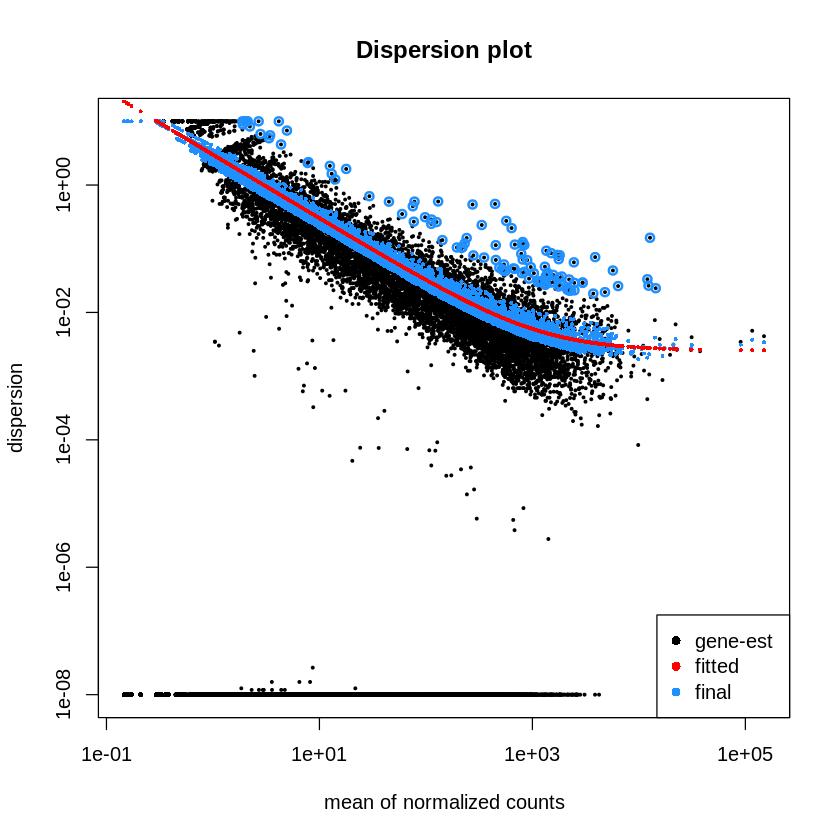

In [8]:
plotDispEsts(dds, main="Dispersion plot")

In [9]:
rld = rlogTransformation(dds)

In [10]:
head(assay(rld))

,control1,control2,control3,Aci1,Aci2,Aci3
WBGene00000001,9.046446,9.127039,9.227911,9.112313,9.125552,9.098033
WBGene00000002,4.175699,4.203708,4.200021,4.198904,4.210454,4.197237
WBGene00000003,4.896361,4.887165,4.859187,4.836387,4.870914,4.807796
WBGene00000004,6.388276,6.362593,6.246351,6.359280,6.359836,6.391675
WBGene00000005,5.753530,5.808044,5.697914,5.758767,5.776546,5.879969
WBGene00000006,3.520516,3.500324,3.515653,3.547439,3.511344,3.502025


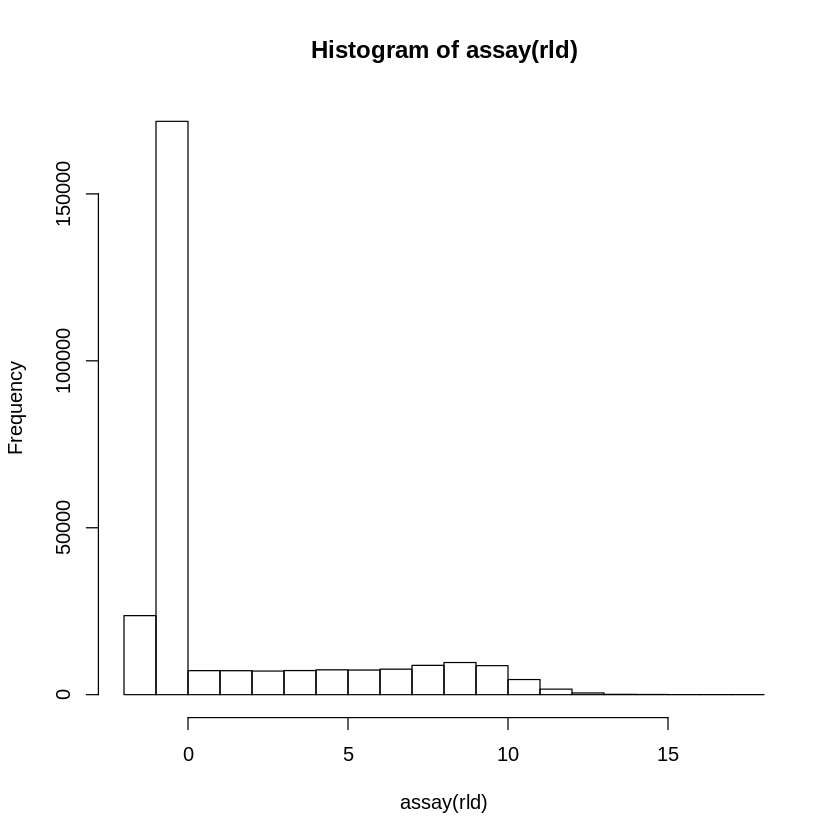

In [11]:
hist(assay(rld))

In [12]:
(mycols = brewer.pal(8, "Dark2")[1:length(unique(condition))])

[1] "#1B9E77" "#D95F02"

In [13]:
sampleDists = as.matrix(dist(t(assay(rld))))

Warning message in plot.window(...):
“"key" is not a graphical parameter”Warning message in plot.window(...):
“"trace" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"key" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"trace" is not a graphical parameter”Warning message in title(...):
“"key" is not a graphical parameter”Warning message in title(...):
“"trace" is not a graphical parameter”

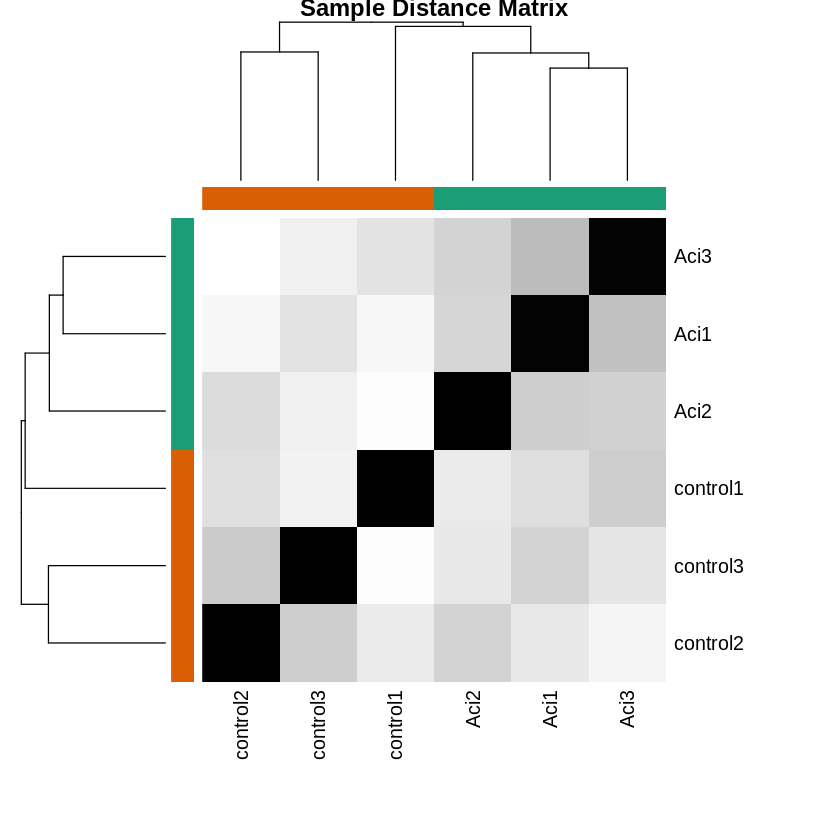

In [14]:
heatmap(as.matrix(sampleDists), key=F, trace="none",
       col=colorpanel(100, "black", "white"),
       ColSideColors=mycols[condition], RowSideColor=mycols[condition],
       margin=c(10,10), main="Sample Distance Matrix")

In [15]:
rld_pca <- function (rld, intgroup = "condition", ntop = 500, colors=NULL, legendpos="bottomleft", main="PCA Biplot", textcx=1, ...) {
  require(genefilter)
  require(calibrate)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC2 (",as.character(pc2var),"%)")
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
  with(as.data.frame(pca$x), textxy(PC1, PC2, labs=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20)
  #     rldyplot(PC2 ~ PC1, groups = fac, data = as.data.frame(pca$rld),
  #            pch = 16, cerld = 2, aspect = "iso", col = colours, main = draw.key(key = list(rect = list(col = colours),
  #                                                                                         terldt = list(levels(fac)), rep = FALSE)))
}

Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:MASS’:

    area

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars



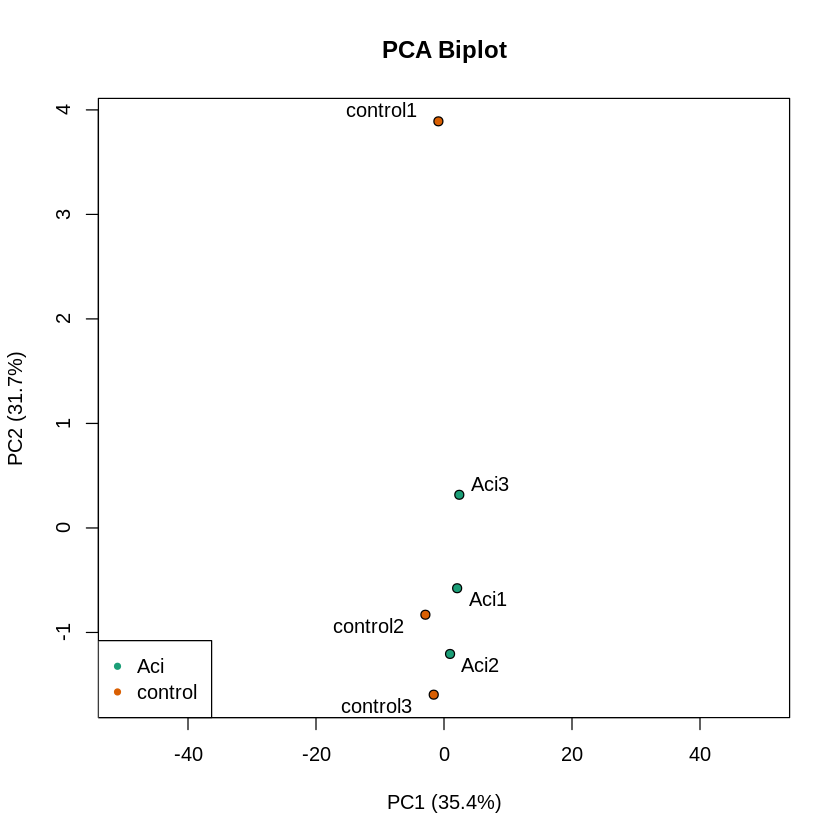

In [16]:
rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-50,50))

In [17]:
res = results(dds)

In [18]:
table(res$padj<0.05)


FALSE  TRUE 
12771    36 

In [19]:
res = res[order(res$padj),]
resdata = merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] = "Gene"
head(resdata)

Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,control1,control2,control3,Aci1,Aci2,Aci3
WBGene00010470,298.94336,1.9438052,0.16747019,11.606873,3.802682e-31,4.870095e-27,95.56658,122.79520,154.71426,418.4667,479.2675,522.8499
WBGene00008390,272.39478,1.4700603,0.15942391,9.221078,2.941290e-20,1.883455e-16,157.81637,134.14601,140.87802,471.4725,376.3631,353.6926
WBGene00019105,101.73661,1.9656133,0.25743712,7.635314,2.252707e-14,9.616807e-11,35.07030,33.02056,57.86062,189.7049,144.8283,149.9349
WBGene00019967,85.23969,1.9627208,0.26365837,7.444182,9.754725e-14,3.123219e-10,26.30273,42.30759,36.47735,141.3488,141.0171,123.9846
WBGene00000715,123.71151,1.4777166,0.22112031,6.682862,2.343196e-11,6.001863e-08,56.98925,75.32815,64.14981,215.7429,175.3185,154.7405
WBGene00000829,22122.69789,0.4719676,0.07318907,6.448608,1.128820e-10,2.409467e-07,16424.30058,19008.49010,20180.77690,24910.8601,27153.4097,25058.3499


In [20]:
write.csv(resdata, file="../results/C_vs_Aci.deseq.csv")

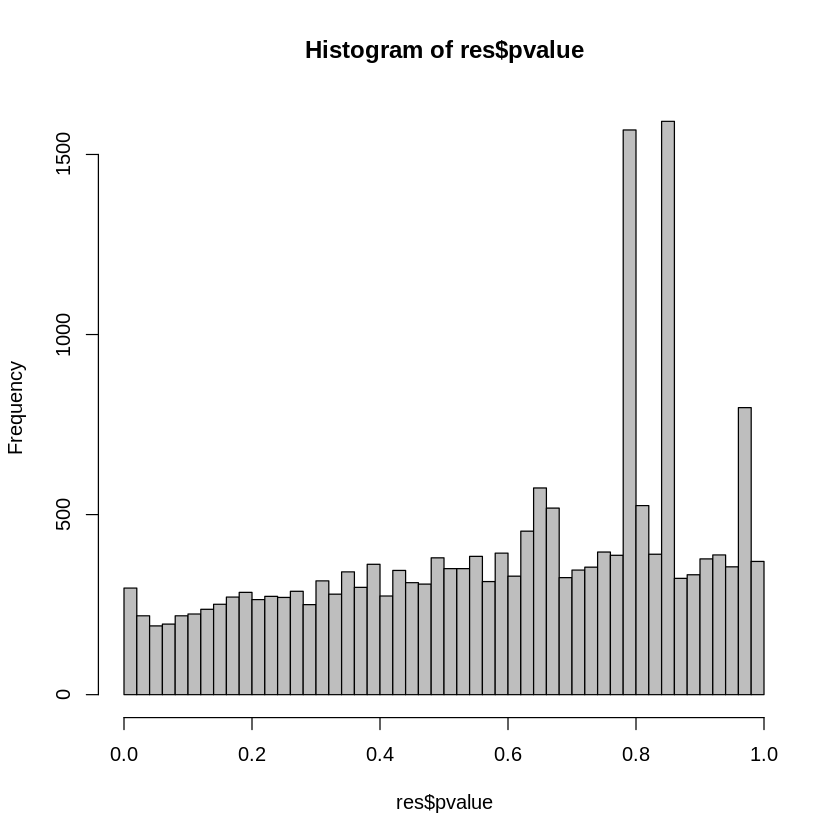

In [21]:
hist(res$pvalue, breaks=50, col="grey")

In [22]:
maplot <- function (res, thresh=0.05, labelsig=TRUE, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=Gene, cex=textcx, col=2))
  }
}

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“27311 x values <= 0 omitted from logarithmic plot”

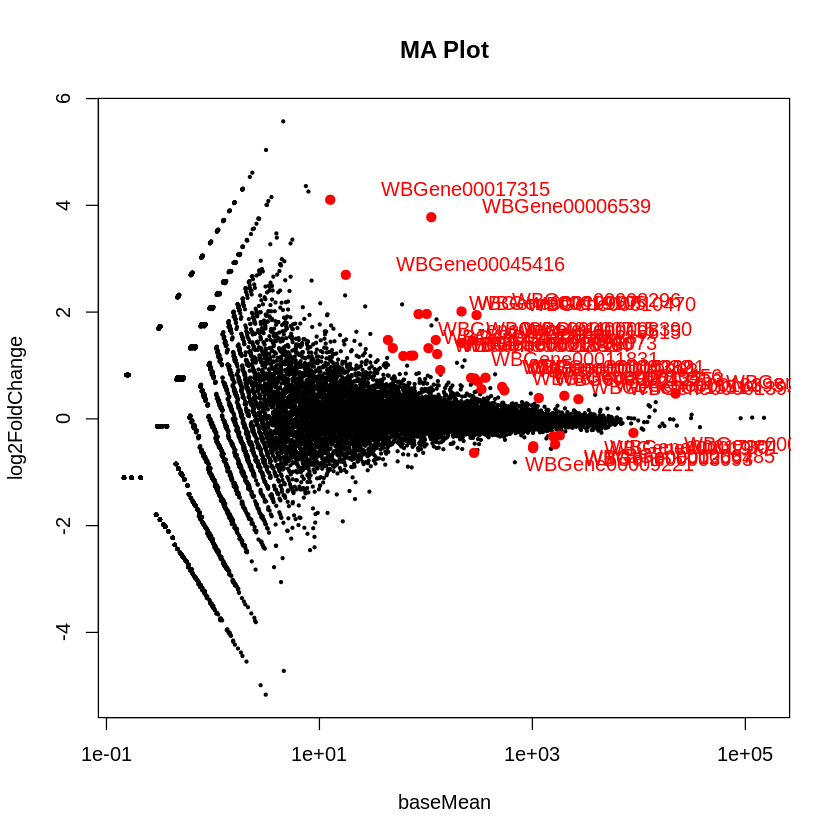

In [23]:
maplot(resdata, main="MA Plot")

In [24]:
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.05, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(pvalue), labs=Gene, cex=textcx, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}

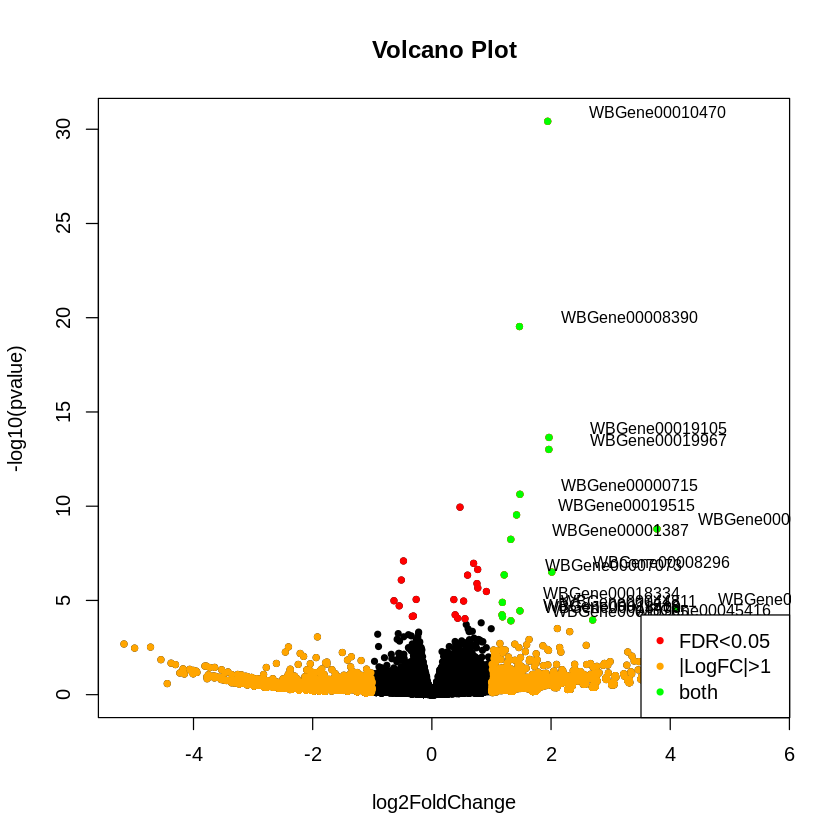

In [25]:
volcanoplot(resdata, lfcthresh=1, sigthresh=0.05, textcx=.8)